# ML Model - Predict Tournament Finish

## Objectives

* This notebook aims to fulfill business requirement 3:  
   - Once they have worked with a player and gained an understanding of their 'strokes gained' performance, the client would like us to deliver a machine learning (ML) model capable of reliably predicting the finishing position of a player based on their current level of skill in each strokes gained area.

## Inputs

* Train, validation and test data:
  - outputs/data/final/train/train_data.csv
  - outputs/data/final/validation/validation_data.csv
  - outputs/data/final/test/test_data.csv
* Scaling pipeline
  - outputs/pipelines/strokes_pipeline.pki


## Outputs

* ML Pipeline to predict tournament finish:
  - outputs/pipelines/tournament_prediction_pipeline.pki

## Additional Comments

* As a Random Forest Regression model was chosen as the final model (rather than Gradient Boosting or XG Boost) to use and hyperparameter tuning could be done on the train data using GridSearchCV with a cross-validation of 5, the validation data was not used in hyperparamter tuning.


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\project-five-golf-data-analytics\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\project-five-golf-data-analytics'

# Download Data and Scaling Pipeline

In [5]:
import pandas as pd

train_data = pd.read_csv("outputs/data/final/train/train_data.csv")
val_data   = pd.read_csv("outputs/data/final/validation/val_data.csv")
test_data  = pd.read_csv("outputs/data/final/test/test_data.csv")
train_data.head()

,player_id,tournament_id,finish_numeric,true_pos,top_ten,mid_band,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,adj_pos
0,9261,401353224,32.0,32.0,0,0,0.20,-0.13,-0.08,0.86,0.65,0.85,0.344444
1,5548,401353224,18.0,18.0,0,1,0.36,0.75,0.31,0.18,1.24,1.60,0.188889
2,4989,401353224,0.0,91.0,0,0,-0.56,0.74,-1.09,0.37,0.02,-0.54,1.000000
3,6015,401353224,0.0,91.0,0,0,-1.46,-1.86,-0.02,0.80,-1.08,-2.54,1.000000
4,3832,401353224,0.0,91.0,0,0,0.53,-0.36,-1.39,0.19,-1.56,-1.04,1.000000


Split features and target for ML model

In [6]:
sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']


X_train = train_data[sg_features]
y_train = train_data['adj_pos']

X_val = val_data[sg_features]
y_val = val_data['adj_pos']

X_test = test_data[sg_features]
y_test = test_data['adj_pos']

y_train.head()

0    0.344444
1    0.188889
2    1.000000
3    1.000000
4    1.000000
Name: adj_pos, dtype: float64

Download Scaling Pipeline.

In [7]:
import joblib
strokes_pipeline = joblib.load("outputs/pipelines/strokes_pipeline.pkl")

## Create the Model

## Random Forest Regressor

Initially, we will start with a Random Forest Regressor. Random Forests can capture nonlinear relationships quickly and effectively, unlike simple linear regression, which assumes a straight-line relationship. Since strokes gained data likely has complex, non-linear interactions, a Random Forest Regressor is a strong starting point for modeling tournament position. We also ahve to ensure sg_total and sg_t2g are not in the model as these are multi-disciplinary metrics and will skew the results.

Validation Metrics:
RMSE: 0.18
MAE: 0.12
R²: 0.76


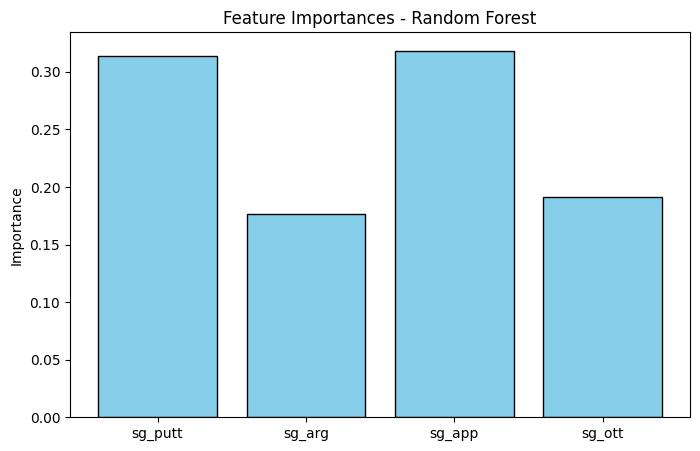

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']

X_train_subset = X_train[sg_features]
X_val_subset   = X_val[sg_features]
X_test_subset  = X_test[sg_features]

pipeline = Pipeline([
    ('scaler', strokes_pipeline),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train_subset, y_train)

y_val_pred = pipeline.predict(X_val_subset)

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("Validation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


model = pipeline.named_steps['model']
importances = model.feature_importances_

plt.figure(figsize=(8,5))
plt.bar(sg_features, importances, color='skyblue', edgecolor='black')
plt.title("Feature Importances - Random Forest")
plt.ylabel("Importance")
plt.show()


This feature importance graph verifies our findings that putting and approach play are the most important factors in a good tournament finishing position.

Next we will assess the ML model performance with a scatter plot.

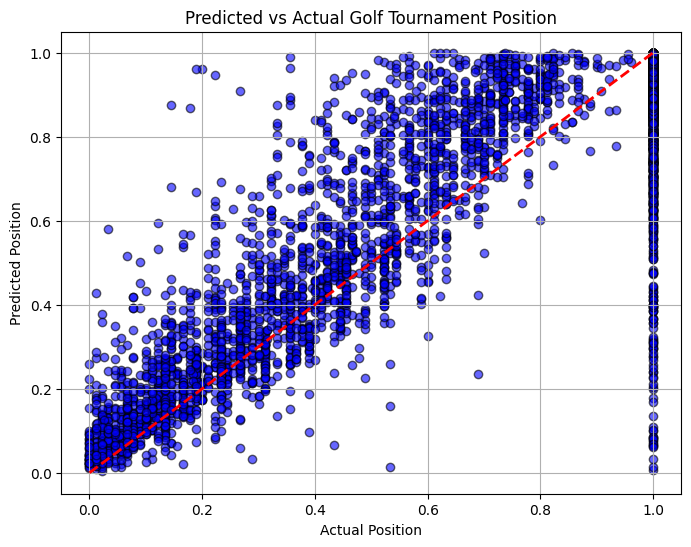

In [9]:
y_val_pred = pipeline.predict(X_val[sg_features])

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Predicted vs Actual Golf Tournament Position")
plt.grid(True)
plt.show()


This has identified that the model is in general overpredicting finishing position. It has also identified that there is still an issue with players who missed the cut (given a numeric value of 91). They are skewing the data and leading to the model overpredicting.
We will try the same model but without players who missed the cut.

Validation Metrics (positions < 90):
RMSE: 0.10
MAE: 0.07
R²: 0.84


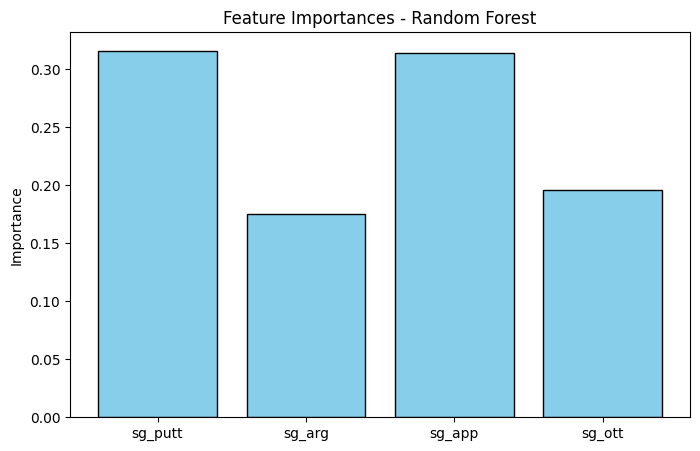

In [10]:
train_filtered = train_data[train_data['true_pos'] < 90].reset_index(drop=True)
val_filtered   = val_data[val_data['true_pos'] < 90].reset_index(drop=True)
test_filtered  = test_data[test_data['true_pos'] < 90].reset_index(drop=True)

sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']

X_train_f = train_filtered[sg_features]
y_train_f = train_filtered['adj_pos']

X_val_f = val_filtered[sg_features]
y_val_f = val_filtered['adj_pos']

X_test_f = test_filtered[sg_features]
y_test_f = test_filtered['adj_pos']


pipeline = Pipeline([
    ('scaler', strokes_pipeline),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])


pipeline.fit(X_train_f, y_train_f)

y_val_pred = pipeline.predict(X_val_f)

rmse = np.sqrt(mean_squared_error(y_val_f, y_val_pred))
mae = mean_absolute_error(y_val_f, y_val_pred)
r2 = r2_score(y_val_f, y_val_pred)

print("Validation Metrics (positions < 90):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


model = pipeline.named_steps['model']
importances = model.feature_importances_

plt.figure(figsize=(8,5))
plt.bar(sg_features, importances, color='skyblue', edgecolor='black')
plt.title("Feature Importances - Random Forest")
plt.ylabel("Importance")
plt.show()


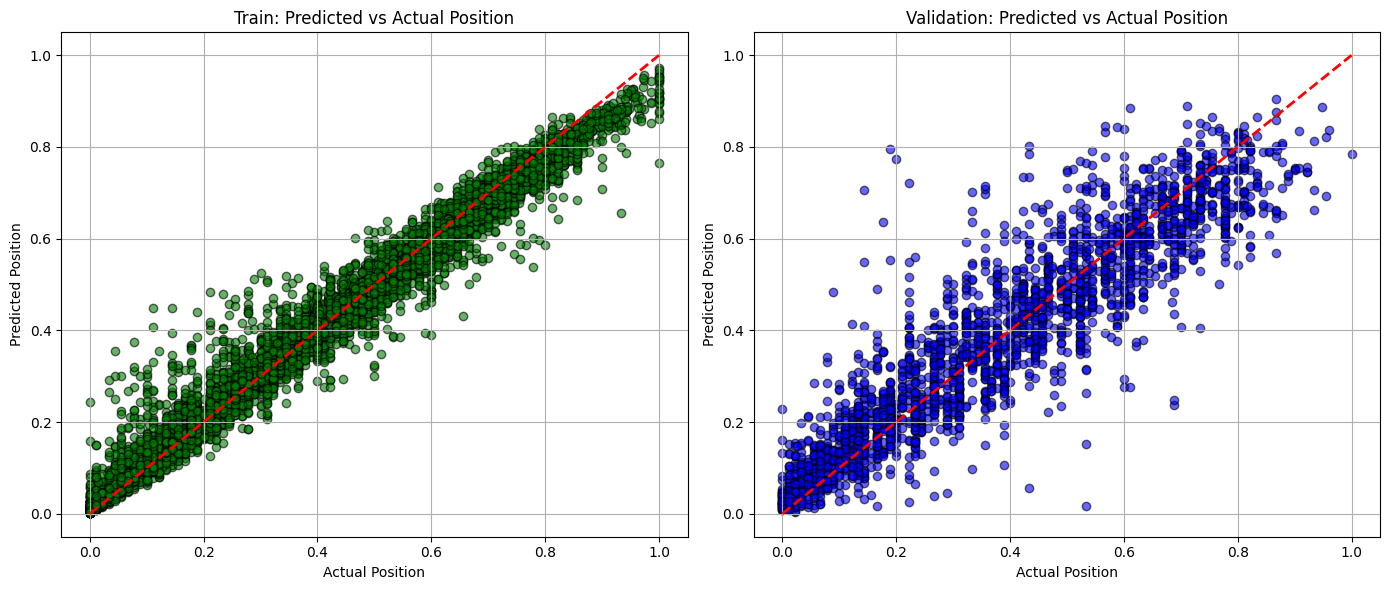

In [11]:
import matplotlib.pyplot as plt

y_train_pred = pipeline.predict(X_train_f)

y_val_pred = pipeline.predict(X_val_f)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train_f, y_train_pred, alpha=0.6, color='green', edgecolor='k')
plt.plot([y_train_f.min(), y_train_f.max()], [y_train_f.min(), y_train_f.max()], 'r--', linewidth=2)
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Train: Predicted vs Actual Position")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_val_f, y_val_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([y_val_f.min(), y_val_f.max()], [y_val_f.min(), y_val_f.max()], 'r--', linewidth=2)
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Validation: Predicted vs Actual Position")
plt.grid(True)

plt.tight_layout()
plt.show()


The results here are better. This leads to a question of what to do about predicting missed cuts. As it is not a key business requirement for our client to predict players who miss the cut and they are hoping to target players with an 11th-30th place finish, we will proceed without using the cut data. As a standard golf tournament usualy has 70 players making the cut, in the final application we may well still be able to make a missed cut prediction if the numeric prediction is >70.

To check, we will try using the Random Forest Regressor but without the scaled strokes gained stats.

In [12]:
train_filtered = train_data[train_data['true_pos'] < 90].reset_index(drop=True)
val_filtered   = val_data[val_data['true_pos'] < 90].reset_index(drop=True)

sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']
X_train_f = train_filtered[sg_features]
y_train_f = train_filtered['adj_pos']
X_val_f   = val_filtered[sg_features]
y_val_f   = val_filtered['adj_pos']

pipeline = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train_f, y_train_f)

y_val_pred = pipeline.predict(X_val_f)
rmse = np.sqrt(mean_squared_error(y_val_f, y_val_pred))
mae = mean_absolute_error(y_val_f, y_val_pred)
r2 = r2_score(y_val_f, y_val_pred)

print("Validation Metrics (positions < 90, no scaling):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

Validation Metrics (positions < 90, no scaling):
RMSE: 0.10
MAE: 0.07
R²: 0.84


The results are identical!

## Gradient Boosting
Gradient Boosting is a method that can capture nonlinear relationships to a high degree. It can often detect subtle interactions between features more effectively than a Random Forest, making it a good next step in creating the most accurate model.


In [13]:
from sklearn.ensemble import GradientBoostingRegressor

train_filtered = train_data[train_data['adj_pos'] < 90].reset_index(drop=True)
val_filtered   = val_data[val_data['adj_pos'] < 90].reset_index(drop=True)

sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']
X_train_f = train_filtered[sg_features]
y_train_f = train_filtered['adj_pos']
X_val_f   = val_filtered[sg_features]
y_val_f   = val_filtered['adj_pos']

gbr_model = GradientBoostingRegressor(
    n_estimators=200,    
    learning_rate=0.1,   
    max_depth=3,         
    random_state=42
)

gbr_model.fit(X_train_f, y_train_f)

y_val_pred = gbr_model.predict(X_val_f)

rmse = np.sqrt(mean_squared_error(y_val_f, y_val_pred))
mae = mean_absolute_error(y_val_f, y_val_pred)
r2 = r2_score(y_val_f, y_val_pred)

print("Validation Metrics (positions < 90, Gradient Boosting):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


Validation Metrics (positions < 90, Gradient Boosting):
RMSE: 0.18
MAE: 0.13
R²: 0.75


This performed slightly worse than the Random Forest. 

## XGBoost

For the final modl assessment we will try XGBoost, which can also capture nonlinear relationships and does not need feature scaling.

In [14]:
import xgboost as xgb

train_filtered = train_data[train_data['adj_pos'] < 90].reset_index(drop=True)
val_filtered   = val_data[val_data['adj_pos'] < 90].reset_index(drop=True)

sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']
X_train_f = train_filtered[sg_features]
y_train_f = train_filtered['adj_pos']
X_val_f   = val_filtered[sg_features]
y_val_f   = val_filtered['adj_pos']

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,     
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_f, y_train_f)

y_val_pred = xgb_model.predict(X_val_f)

rmse = np.sqrt(mean_squared_error(y_val_f, y_val_pred))
mae = mean_absolute_error(y_val_f, y_val_pred)
r2 = r2_score(y_val_f, y_val_pred)

print("Validation Metrics (positions < 90, XGBoost):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


Validation Metrics (positions < 90, XGBoost):
RMSE: 0.18
MAE: 0.13
R²: 0.75


## Model comparisons

| Model                     | RMSE  | MAE   | R²   |
|----------------------------|-------|-------|------|
| Random Forest | 0.10  | 0.07  | 0.84 |
| Gradient Boosting     | 0.18  | 0.13  | 0.75 |
| XGBoost               | 0.18  | 0.13  | 0.75 |


All three models were evaluated on finished players (positions < 90), but Random Forest clearly outperformed both Gradient Boosting and XGBoost.

Random Forest achieved the lowest RMSE (0.10), MAE (0.07), and highest R² (0.84).

Gradient Boosting and XGBoost performed similarly to each other but worse than Random Forest (RMSE 0.18, MAE 0.13, R² 0.75).

This indicates that, for this dataset with a small number of strokes gained features, Random Forest is better at capturing the relationships in the data.

We will attempt to fine-tune the hyperparameters of the random forest model.


## Hyperparamater Optimisation
Firstly, we wil create a custom class that runs GridSearchCV for each set of hyperparameters, then summarises the results in a table for easy comparison.

In [16]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimisationSearch:
    def __init__(self, models, params):
        """
        models: dict of sklearn pipelines or estimators, e.g., {"rf": pipeline}
        params: dict of hyperparameter grids, keys matching models
        """
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=5, n_jobs=-1, verbose=1, scoring=None, refit=True):
        """
        Fit GridSearchCV for all models provided.
        """
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key}...\n")
            
            model = self.models[key]
            param_grid = self.params[key]
            
            gs = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                scoring=scoring,
                refit=refit
            )
            
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        """
        Returns a DataFrame summarising cross-validation results for all models.
        """
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores)
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params_list = self.grid_searches[k].cv_results_['params']
            splits = [f'split{i}_test_score' for i in range(self.grid_searches[k].cv)]
            for i, p in enumerate(params_list):
                scores = [self.grid_searches[k].cv_results_[split][i] for split in splits]
                rows.append(row(k, scores, p))

        df = pd.DataFrame(rows).sort_values([sort_by], ascending=False)
        return df, self.grid_searches


## Random Forest Regressor

We will test the hyperparameters of the Random Forest Model. As there was no difference with the strokes gained data scaled, we will not proceed with scaled data.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

models_rf = {
    "RandomForest": Pipeline([
        ('model', RandomForestRegressor(random_state=42))
    ])
}

params_rf = {
    "RandomForest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [3, 5, None]
    }
}

search = HyperparameterOptimisationSearch(models=models_rf, params=params_rf)

search.fit(
    X_train_f, 
    y_train_f,
    scoring='r2',
    n_jobs=-1,
    cv=5
)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary



Running GridSearchCV for RandomForest...

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,model__max_depth,model__n_estimators,estimator,min_score,max_score,mean_score,std_score
5,NaN,200,RandomForest,0.709928,0.831742,0.771798,0.048145
4,NaN,100,RandomForest,0.709050,0.831019,0.770762,0.048122
3,5.0,200,RandomForest,0.600075,0.716283,0.655839,0.043487
2,5.0,100,RandomForest,0.600277,0.715023,0.655452,0.043327
0,3.0,100,RandomForest,0.449572,0.542946,0.492521,0.036135
1,3.0,200,RandomForest,0.448325,0.543897,0.492355,0.036151


Next we will test the new hyperparameters on the test data and convert the result back to a final finishing position rathen than a scaled finishing position.

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

tuned_rf_pipeline = Pipeline([
    ('model', RandomForestRegressor(
        n_estimators=200,      
        max_depth=None,        
        random_state=42
    ))
])


X_train_f = train_data[train_data['adj_pos'] < 1][sg_features]
y_train_f = train_data[train_data['adj_pos'] < 1]['adj_pos']

X_test_f = test_data[test_data['adj_pos'] < 1][sg_features]
y_test_f = test_data[test_data['adj_pos'] < 1]['adj_pos']

tuned_rf_pipeline.fit(X_train_f, y_train_f)

y_test_pred = tuned_rf_pipeline.predict(X_test_f)

mae_norm = mean_absolute_error(y_test_f, y_test_pred)
rmse_norm = np.sqrt(mean_squared_error(y_test_f, y_test_pred))

print(f"Test MAE (adj_pos 0-1): {mae_norm:.3f}")
print(f"Test RMSE (adj_pos 0-1): {rmse_norm:.3f}")

test_filtered = test_data[test_data['adj_pos'] < 1].copy()
test_filtered['y_pred'] = y_test_pred

max_pos = test_filtered.groupby('tournament_id')['true_pos'].transform('max')

mae_positions = mae_norm * (max_pos - 1).mean()
rmse_positions = rmse_norm * (max_pos - 1).mean()

print(f"Test MAE (positions): {mae_positions:.2f}")
print(f"Test RMSE (positions): {rmse_positions:.2f}")


Test MAE (adj_pos 0-1): 0.065
Test RMSE (adj_pos 0-1): 0.091
Test MAE (positions): 4.64
Test RMSE (positions): 6.49


As the MAE on the test data is <5, the model can be considered a success and ready for use.

## Plot Test Data Prediction v Actual

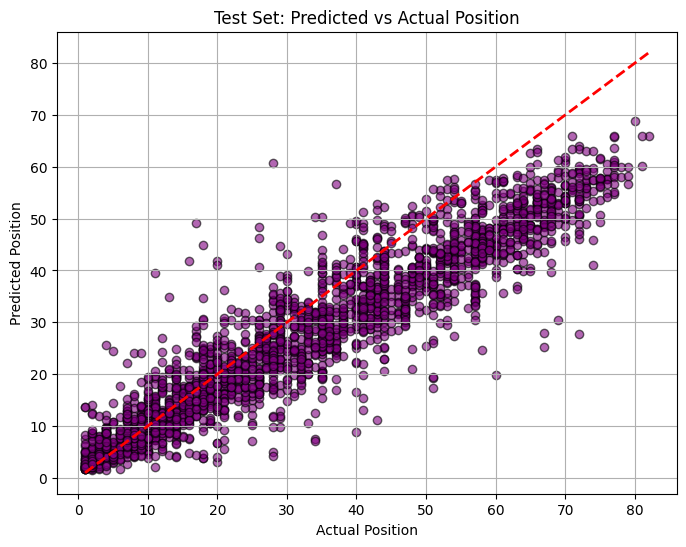

In [20]:
y_test_pred_pos = y_test_pred * (max_pos - 1) + 1
y_test_actual = test_filtered['true_pos']

plt.figure(figsize=(8,6))
plt.scatter(y_test_actual, y_test_pred_pos, alpha=0.6, color='purple', edgecolor='k')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--', linewidth=2)
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Test Set: Predicted vs Actual Position")
plt.grid(True)
plt.show()



Although the model shows some underfitting, particularly for higher finishing positions (poorer performers), it is more accurate for the level of players the client is interested in (top 30, working toward the top 10). We will pass the results on to the client, making them aware of the underfitting among lower-ranked performers.

## Save the pipeline to the repo

In [ ]:
pipeline_path = "outputs/pipelines/tournament_prediction_pipeline.pkl"

joblib.dump(pipeline, pipeline_path)

print(f"Pipeline saved to: {pipeline_path}")

Pipeline saved to: outputs/pipelines/tournament_prediction_pipeline.pkl
